# practicalMixGaussB

The goal of this part of the lab is to fit a mixture of gaussians model to some one-dimensional data. To do this, we will first generate some data from a known mixture of gaussians model and fit our own mixture of gaussians model to the generated data. The parameters from our estimated mixture of gaussians model should roughly match those of the original known model. 

You should use this template for your code and fill in the missing 
sections marked "TO DO."

PLEASE NOTE (again): You should NOT be using functions like multivariate_normal.pdf and normfit or any other numpy functions for fitting your distributions in this or further parts of this practical. Optionally, you can try comparing your results to those produced by those functions, but our goal here is to learn what is happening!

In [13]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import time

%matplotlib inline

## Construct Ground Truth Mixture of Gaussians Model and Plot Some Points

Define some true parameters for our grounf truth mixture of $k$ Gaussians model. We will represent the mixtures of Gaussians as a python dictionary. Not that we are working in one dimension, but if we were to require $d$ dimenisions, the mean field would be a $d \times k$ matrix and the cov field would be a $d \times d \times k$ matrix. 

In [14]:
mixGaussTrue = dict()
mixGaussTrue['k'] = 2 # number of gaussians
mixGaussTrue['d'] = 1 # dimension of the data
mixGaussTrue['weight'] = np.array([0.3, 0.7]) # weight assigned to each gaussian
mixGaussTrue['mean'] = np.array([[-1,1.5]]) # the mean for each gaussian 
mixGaussTrue['cov'] = np.reshape([0.5, 0.25], newshape=(1,1,2)) # the covariance for each gaussian

C:\Users\44774\AppData\Local\Temp\ipykernel_22416\1051392171.py:6: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  mixGaussTrue['cov'] = np.reshape([0.5, 0.25], newshape=(1,1,2)) # the covariance for each gaussian


**getGaussProb**, **sampleFromDiscrete**, and **drawEMData1d** are helper functions. 

In [15]:
# subroutine to return gaussian probabilities
def getGaussProb(x,mean,var):   
    """
    Returns the likelihood that each data point in x belongs to the Gaussian described by mean and 
    var.
    
    Keyword arguments:
    x -- 1 by n vector of data points. n is the number of data points.
    mean -- scalar containing the mean parameter of the Gaussian distribution.
    var -- scalar containing the variance parameter of the Gaussian distribution.
    
    Returns: 
    prob -- scalar containing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by mean and var.
    """
    mean = np.squeeze(mean)
    var = np.squeeze(var)
    prob = np.exp(-0.5*((x-mean)**2)/(var))
    prob = prob/ np.sqrt(2*np.pi*var) 
    return prob

In [16]:
def sampleFromDiscrete(probDist): 
    """
    Draws a random sample from a discrete probability distribution using a rejection sampling method.  
    
    Keyword arguments:
    probDist -- discrete probability ditrubtion to sample from.
    
    Returns: 
    r -- sampled point.
    """

    nIndex = len(probDist)
    while True:
        #choose random index 
        r=int(np.floor(np.random.uniform()*nIndex)) 
        #choose random height
        randHeight = np.random.uniform()
        #if height is less than probability value at this point in the
        # histogram then select 
        if randHeight<probDist[r]: 
            break
    return r 

In [17]:
def drawEMData1d(data, mixGauss):
    """
    Draw the data, data, in histogram form and plot the mixtures of Gaussian model, mixGauss, on top of it.
    
    Keyword arguments:
    data -- 1 by n vector of data points.
    mixGauss -- dict with mixture of gaussian information.

    """
    # delete previous plot if it exists 
    # hold off;
    # bin the data to make a histogram
                                                                                                          
    binWidth = 0.1
    binMin = -4.0
    binMax = 4.0
    nSteps = int(np.ceil((binMax - binMin) / binWidth))
                                                                                                          
    nDims, nData = data.shape
                                                                                                          
    xHist = np.linspace(binMin, binMax, nSteps, endpoint=True)
    xHistExt = np.append(xHist, np.inf) 
    yHist, _ = np.histogram(data, xHistExt)
                                                                                                          
    yHist = yHist / (nData * binWidth)
    plt.cla()
    plt.bar(xHist, yHist, binWidth, edgecolor='b') 
                                                                                                          
    # calculate Gaussian data
    nGauss = mixGauss['k']
    gaussEnvEst = np.zeros(xHist.shape)
    for cGauss in range(nGauss):
        # calculate weighted Gaussian values
        gaussProb = mixGauss['weight'][cGauss] * getGaussProb(xHist, mixGauss['mean'][:,cGauss],          
                                                              mixGauss['cov'][:, :, cGauss])              
        plt.plot(xHist, gaussProb, 'm-')  # weighted components of MoG                                    
        # add to form envelope                                                                            
        gaussEnvEst = gaussEnvEst + gaussProb 
                                                                                                          
    plt.plot(xHist, gaussEnvEst, 'g-')  # final mixture of Gaussians                                      
                                                                                                          
    # tidy up plot                                                                                        
    plt.xlabel('Data Value')                                                                              
    plt.ylabel('Probability Density')                                                                     
    # set(gca,'Box','Off');                                                                               
    # set(gcf,'Color',[1 1 1]);                                                                           
    plt.xlim((binMin, binMax))                                                                            
    plt.ylim((0, max(yHist) * 1.5))       
    plt.show()                                                                
                                                                                                          
    return                                                                                                
    

**TODO HERE:**

Complete the TO DO in this function before moving on. 



In [18]:
def mixGaussGen1d(mixGauss, nData):  
    """
    Generates data from a one-dimensional mixture of Gaussians model. 
    
    Keyword arguments:
    mixGauss -- dict containing the mixture of gaussians arguments.
    nData -- number of data points to generate.
    
    Returns: 
    data -- 1 by nData, generated data points. 
    """
    
    # create space for output data generated                                                                               
    data = np.zeros(shape=(1, nData))                                                                            
    # for each data point                                                                                        
    for cData in range(nData):                                                                                   
        # randomly choose Gaussian component according to probability distributions                                        
        h = sampleFromDiscrete(mixGauss['weight'])                                                               
        # draw a sample from the appropriate Gaussian distribution                                               
        mean_h = mixGauss['mean'][:, h]
        cov_h = mixGauss['cov'][:, :, h]
        
        # Given it's 1D, cov_h is the variance (not covariance matrix)
        std_h = np.sqrt(cov_h) # standard deviation is sqrt of variance
        
        # draw sample from the chosen Gaussian with its mean and sd
        data[:, cData] = np.random.normal(mean_h, std_h)
                                                                                                         
    return data                                                                                                  

With all the helper functions complete, we can now generate and plot some points from our model. The blue bars are the histogram of the generated points. The green curve is what the complete mixture of gaussians model looks like. The pink curves are the component gaussians. 

**Comments**:
- **Plot**: 
    1. The histogram represents the distribution of the generated data points: The magenta curves correspond to the individual Gaussian components, while the green curve is the overall probability density of the Gaussian mixture model.
    2. Ideally, the histogram should closely match the shape of the overall Gaussian mixture curve, which means that the generated data should be distributed in such a way that the two clusters or peaks in the data align with the means and variances of the Gaussian components.
- **Validation**: To improve the robustness and representativeness of your results, consider
    1. **Increasing the sample size** to reduce random fluctuations in the histogram
    2. Validating and potentially **adjusting the Gaussian parameters** in mixGaussTrue for a better fit
    3. **Running the experiment multiple times** to ensure consistent patterns
    4. Using **statistical tests to quantitatively compare the generated data with the theoretical distribution**.


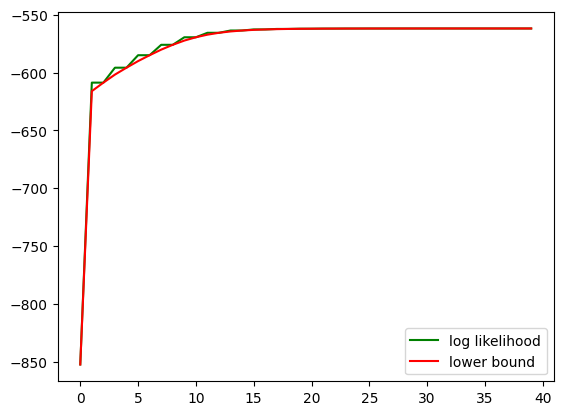

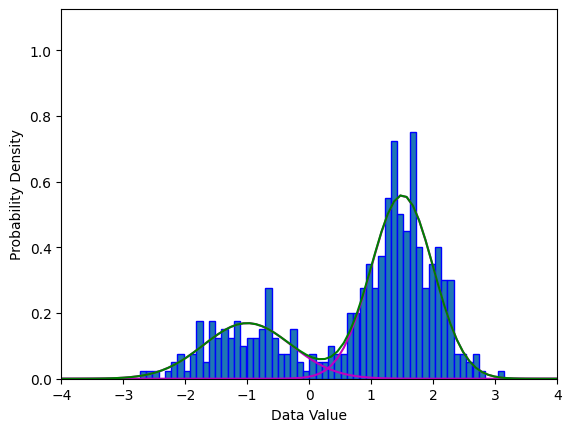

In [19]:
# define number of samples to generate
nData = 400

#generate data from the mixture of Gaussians
#make sure you've filled out the todo above! 
data = mixGaussGen1d(mixGaussTrue,nData)

#plot! 
fig,ax = plt.subplots(1,1)
drawEMData1d(data,mixGaussTrue)

## Estimate MoG using the E-M Algorithm
Here we want to use the E-M algorithm to fit a MoG model to our data points. 

**TODO HERE:** 

Fill out the missing parts below. 

In [20]:
def getMixGaussBound(data, mixGaussEst, responsibilities):                                                  
    """
    Calculate the bound on the log likelihood for the whole data set under a mixture of Gaussians model.  
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict 
    aining the mixture of gaussians parameters.
    responsibilities -- k by n vector containing the responsibility of this data point for each Gaussian. 
    
    Returns: 
    bound -- scalar containing the bound on the log likelihood.
    
    """
    # find total number of data items                                                                       
    nDims, nData = data.shape
    nGauss = mixGaussEst['k']                                                                               
                                                                                                            
    # initialize bound                                                                                      
    bound = 0                                                                                               
    
    curCov = mixGaussEst['cov']                                                                             
    curWeight = mixGaussEst['weight']                                                                    
    curMean = mixGaussEst['mean']                                                                           
     
    # run through each data item                                                                            
    for cData in range(nData):                                                                              
        # extract this data                                                                                 
        thisData = data[:, cData]                                                                           
        # extract this q(h)                                                                                 
        thisQ = responsibilities[:, cData]                                                                  
                                                                                                            
        # TO DO - calculate contribution to bound of this datapoint                                         
        # Replace this                                                                                      
        boundValue = 0
        
        # For each Gaussian, calculate its contribution
        for cGauss in range(nGauss):
            # Extract the parameters for this Gaussian
            mean_k = curMean[:, cGauss]
            cov_k = curCov[:, :, cGauss]
            weight_k = curWeight[cGauss]
            
            # Calculate the Gaussian likelihood for this data point P(x_n|h_k)
            gaussProb = getGaussProb(thisData, mean_k, cov_k)
            
            # Calculate the contribution to the bound
            if thisQ[cGauss] > 0:
                boundValue += thisQ[cGauss] * (
                    np.log(gaussProb) + np.log(weight_k) - np.log(thisQ[cGauss])
                )
                
        # add this data point's contribution to the total bound                                                                        
        bound += boundValue

    return np.array(bound).item()

**TODO HERE:** 

Fill out the missing parts below. 

The log likelihood is taken since the raw likelihood value could be too small for our machine's percision. 

In [21]:
def getMixGaussLogLike(data, mixGaussEst):
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    logLike = 0
    
    # get parameters of the current mixture model
    curCov = mixGaussEst['cov']
    curWeight = mixGaussEst['weight']
    curMean = mixGaussEst['mean']
    nGauss = mixGaussEst['k'] # number of Gaussians
                                                                                                       
    # run through each data item                                                                       
    for cData in range(nData):                                                                         
        thisData = data[:, cData]    
        
        # TO DO (e) - calculate likelihood of this data point under mixture of                         
        # Initialize the likelihood for this data point to 0                                                              
        like = 0
        
        # Sum the weighted likelihoods for each Gaussian component
        for cGauss in range(nGauss):
            mean_k = curMean[:, cGauss]
            cov_k = curCov[:, :, cGauss]
            weight_k = curWeight[cGauss]
            
            # Get the likelihood of the data point under the Gaussian
            gaussProb = getGaussProb(thisData, mean_k, cov_k)
            
            # Add weighted Gaussian likelihood to the total likelihood
            like += weight_k * gaussProb
                                                                                                       
        # add to total log like                                                                        
        logLike += np.log(like)                                                               
                                                                                                       
    return  np.array(logLike).item()                                                                                                                                                                     

**TODO HERE:** 

Fill out the missing parts below. 

In [22]:
def fitMixGauss1d(data, k):   
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape                                                                                                                                                                                                                                                                                   
    responsibilities = np.zeros(shape=(k, nData))                                                                    
                                                                                                                     
    # we will initialize the values to random values                                                                 
    mixGaussEst = dict()                                                                                             
    mixGaussEst['d'] = 1                                                                                             
    mixGaussEst['k'] = k                                                                                             
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))                                                             
    mixGaussEst['mean'] = 2 * np.random.randn(1, k)                                                                  
    mixGaussEst['cov'] = 0.1 + 1.5*np.random.uniform(size=(1,1,2))                                                   
                                                                                                                     
    # calculate initial log-likelihood                                                                                   
    # TO DO - fill in this routine                                                                                   
    logLike = getMixGaussLogLike(data, mixGaussEst)                                                                  
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))                                                       
                                                                                                                     
    nIter = 20                                                                                                    
                                                                                                                     
    logLikeVec = np.zeros(shape=(2 * nIter))                                                                         
    boundVec = np.zeros(shape=(2 * nIter)) 
    
    fig,ax = plt.subplots(1,1)
                                                                                                                     
    for cIter in range(nIter):                                                                                       
                                                                                                                     
        # ===================== =====================                                                                
        # Expectation step                                                                                           
        # ===================== =====================                                                                
        curCov = mixGaussEst['cov']                                                                                  
        curWeight = mixGaussEst['weight']                                                                            
        curMean = mixGaussEst['mean']                                                                                
        for cData in range(nData):           
            thisData = data[:, cData]
            # Calculate the responsibility for each Gaussian
            denom = 0
            for cGauss in range(k):
                mean_k = curMean[:, cGauss]
                cov_k = curCov[:, :, cGauss]
                weight_k = curWeight[cGauss]
                
                # Calculate the likelihood
                denom += weight_k * getGaussProb(thisData, mean_k, cov_k)
                
            for cGauss in range(k):
                mean_k = curMean[:, cGauss]
                cov_k = curCov[:, :, cGauss]
                weight_k = curWeight[cGauss]
                
                # Compute responsibility using Bayes' rule
                responsibilities[cGauss, cData] = (weight_k * getGaussProb(thisData, mean_k, cov_k)) / denom


        # calculate the log likelihood                                                                               
        logLike = getMixGaussLogLike(data, mixGaussEst)                                                              
        print('Log Likelihood After E-Step Iter {} : {:4.3f}\n'.format(cIter, logLike))                              
                                                                                                                     
        # calculate the bound                                                                                        
        # TO DO - Fill in this routine                                                                               
        bound = getMixGaussBound(data, mixGaussEst, responsibilities)                                                
        print('Bound After E-Step Iter {} : {:4.3f}\n'.format(cIter, bound))     
        
        logLikeVec[2 * cIter] = logLike                                                                              
        boundVec[2 * cIter] = bound                                                                                  
        # ===================== =====================                                                                
        # Maximization Step                                                                                          
        # ===================== =====================                                                                
        # for each constituent Gaussian                                                                        
        for cGauss in range(k):
            # Update weights (normalized sum of responsibilities)
            mixGaussEst['weight'][cGauss] = np.sum(responsibilities[cGauss, :]) / nData
            
            # Update means (responsibility-weighted sum of data points)
            mixGaussEst['mean'][:, cGauss] = np.sum(responsibilities[cGauss, :] * data, axis=1) / np.sum(responsibilities[cGauss, :])
            
            # Update covariance (weighted average of squared distances from the mean)
            weighted_diff = (data - mixGaussEst['mean'][:, cGauss].reshape(nDims, 1)) ** 2
            mixGaussEst['cov'][:, :, cGauss] = np.sum(responsibilities[cGauss, :] * weighted_diff, axis=1) / np.sum(responsibilities[cGauss, :])
        
        # Draw the new solution
        drawEMData1d(data, mixGaussEst)
        time.sleep(0.7)
        fig.canvas.draw()
                                                                                                                     
        # calculate the log likelihood                                                                               
        logLike = getMixGaussLogLike(data, mixGaussEst)                                                              
        print('Log Likelihood After M-Step Iter {} : {:4.3f}\n'.format(cIter, logLike))                              
                                                                                                                     
        # calculate the bound                                                                                        
        bound = getMixGaussBound(data, mixGaussEst, responsibilities)                                                
        print('Bound After M-Step Iter {} : {:4.3f}\n'.format(cIter, bound)) 
                                                                                                                  
        logLikeVec[2 * cIter + 1] = logLike                                                                          
        boundVec[2 * cIter + 1] = bound                                                                              
                                                                                                                     
    # plot the final likelihood and bound
    plt.figure()                                                                                                     
    plt.plot(logLikeVec, 'g',label='log likelihood')                                                                                        
    plt.plot(boundVec, 'r',label='lower bound')  
    plt.legend()
                                                                                                                     
    return mixGaussEst                                                                                               

### Time to put it all together!

Make sure you've filled all the TO DOs above! 

**Comment** (based on one of the runs):
1. **Plot**: In the transition from iteration 0 to iteration 19, the EM algorithm shows substantial improvement: the initial poor fit evolving into a refined model where the individual Gaussian components (magenta curves) accurately capture the data distribution's peaks, and the overall Gaussian mixture (green curve) provides a strong fit to the histogram. This demonstrated the algorithm's effectiveness at progressively adjusting the parameters to match the data.
2. **Validation and Robustness**: While the final model appears to fit the data well, the results could still be sensitive to the **initial random parameter settings**. Running the EM algorithm multiple times with different initializations could help ensure that the model consistently converges to a good solution. **Increasing the number of iterations or incorporating a convergence criterion** based on changes in the log-likelihood could further refine the model.
3. **Possible Limitations**: The model might struggle if the underlying distribution is more complex or if there are outliers in the data. Considering techniques like model selection (e.g., using the Bayesian Information Criterion to choose the optimal number of Gaussian components) or robust estimation methods could strengthen the analysis.

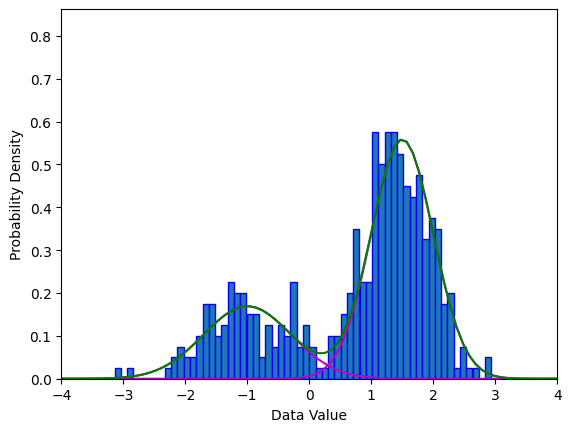

Log Likelihood Iter 0 : -956.619

Log Likelihood After E-Step Iter 0 : -956.619

Bound After E-Step Iter 0 : -956.619



C:\Users\44774\AppData\Local\Temp\ipykernel_22416\1675487380.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  responsibilities[cGauss, cData] = (weight_k * getGaussProb(thisData, mean_k, cov_k)) / denom


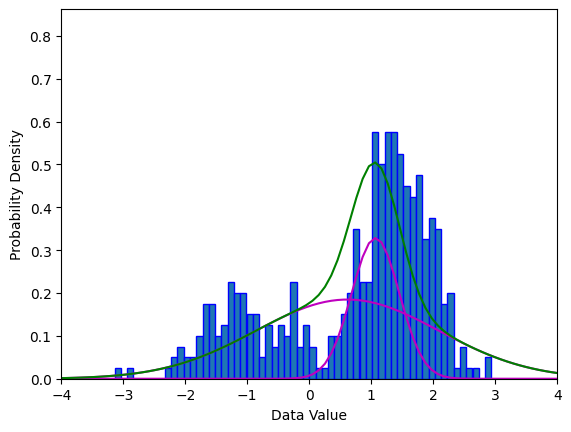

Log Likelihood After M-Step Iter 0 : -645.769

Bound After M-Step Iter 0 : -678.488

Log Likelihood After E-Step Iter 1 : -645.769

Bound After E-Step Iter 1 : -645.769



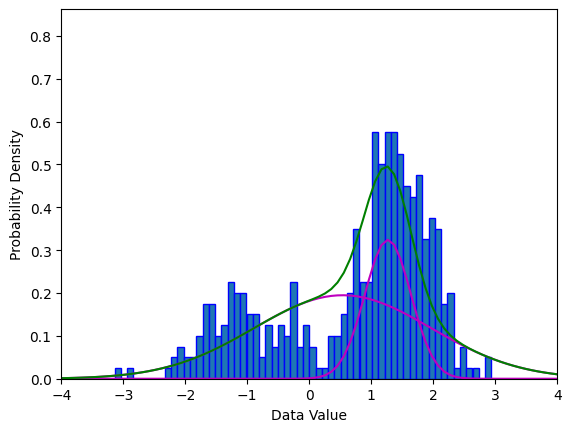

Log Likelihood After M-Step Iter 1 : -617.129

Bound After M-Step Iter 1 : -628.464

Log Likelihood After E-Step Iter 2 : -617.129

Bound After E-Step Iter 2 : -617.129



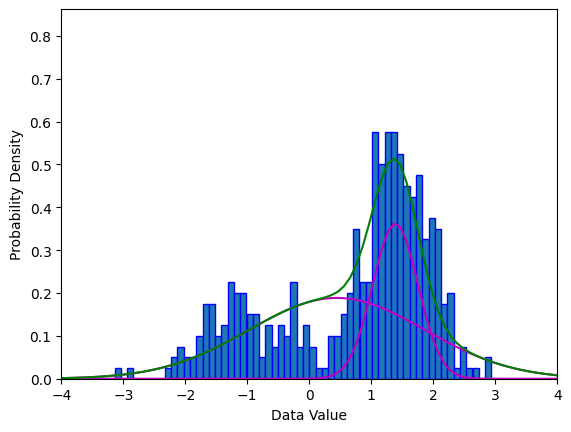

Log Likelihood After M-Step Iter 2 : -601.998

Bound After M-Step Iter 2 : -608.756

Log Likelihood After E-Step Iter 3 : -601.998

Bound After E-Step Iter 3 : -601.998



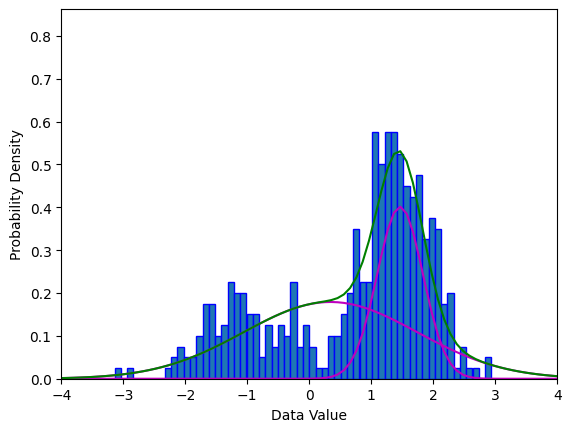

Log Likelihood After M-Step Iter 3 : -592.229

Bound After M-Step Iter 3 : -596.667

Log Likelihood After E-Step Iter 4 : -592.229

Bound After E-Step Iter 4 : -592.229



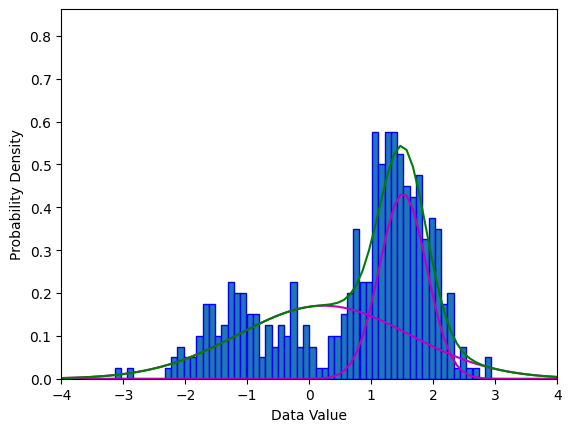

Log Likelihood After M-Step Iter 4 : -585.854

Bound After M-Step Iter 4 : -588.706

Log Likelihood After E-Step Iter 5 : -585.854

Bound After E-Step Iter 5 : -585.854



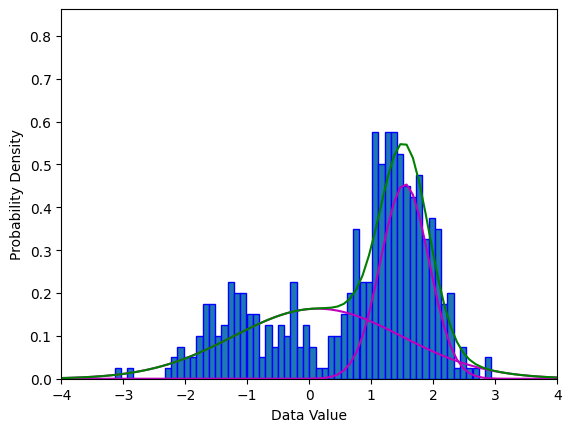

Log Likelihood After M-Step Iter 5 : -581.775

Bound After M-Step Iter 5 : -583.587

Log Likelihood After E-Step Iter 6 : -581.775

Bound After E-Step Iter 6 : -581.775



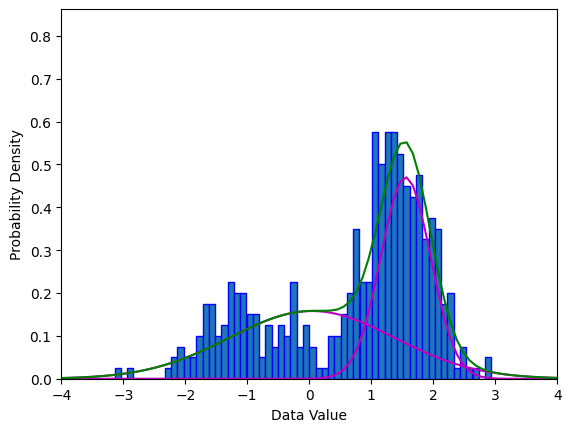

Log Likelihood After M-Step Iter 6 : -579.086

Bound After M-Step Iter 6 : -580.297

Log Likelihood After E-Step Iter 7 : -579.086

Bound After E-Step Iter 7 : -579.086



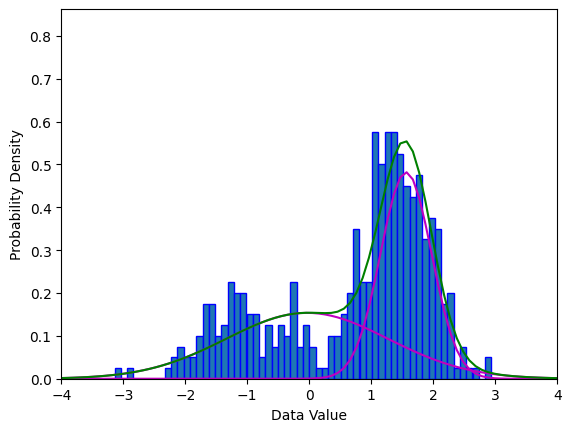

Log Likelihood After M-Step Iter 7 : -577.179

Bound After M-Step Iter 7 : -578.056

Log Likelihood After E-Step Iter 8 : -577.179

Bound After E-Step Iter 8 : -577.179



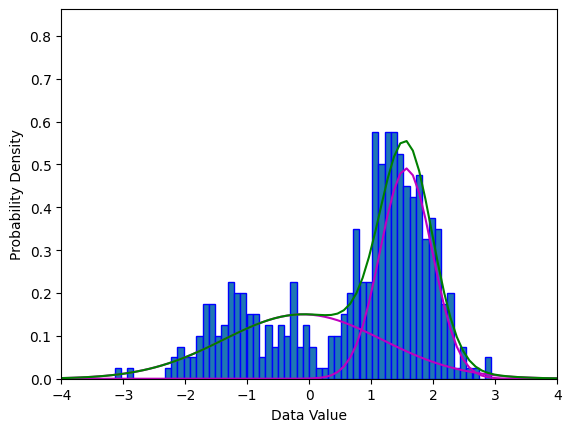

Log Likelihood After M-Step Iter 8 : -575.723

Bound After M-Step Iter 8 : -576.404

Log Likelihood After E-Step Iter 9 : -575.723

Bound After E-Step Iter 9 : -575.723



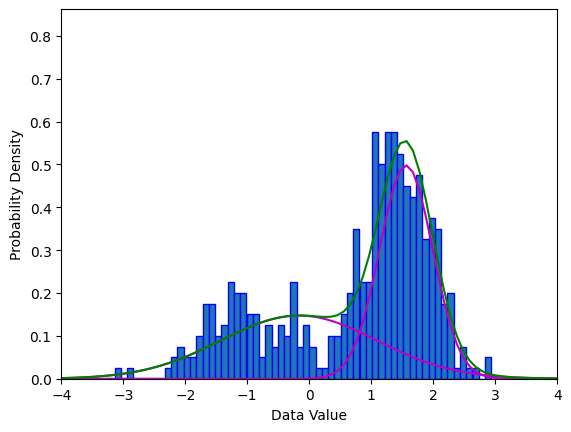

Log Likelihood After M-Step Iter 9 : -574.538

Bound After M-Step Iter 9 : -575.101

Log Likelihood After E-Step Iter 10 : -574.538

Bound After E-Step Iter 10 : -574.538



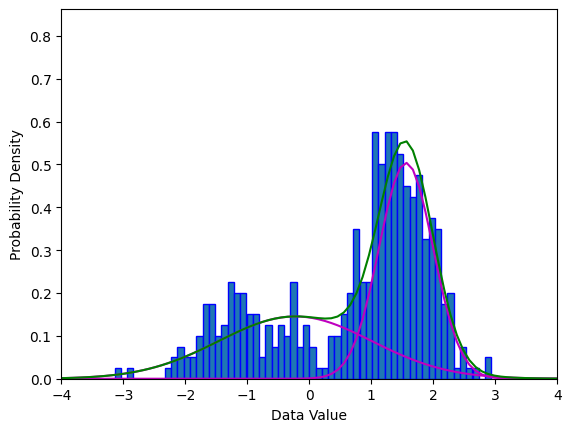

Log Likelihood After M-Step Iter 10 : -573.517

Bound After M-Step Iter 10 : -574.009

Log Likelihood After E-Step Iter 11 : -573.517

Bound After E-Step Iter 11 : -573.517



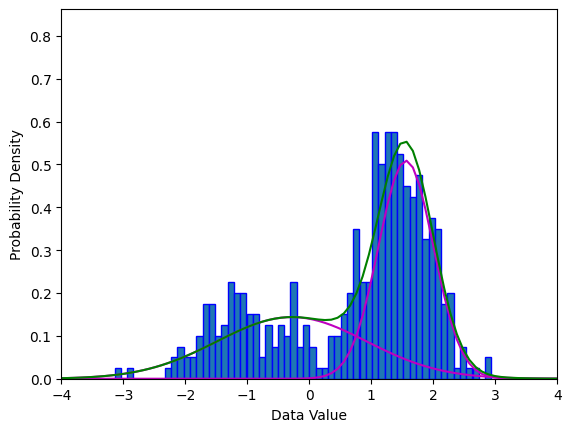

Log Likelihood After M-Step Iter 11 : -572.587

Bound After M-Step Iter 11 : -573.041

Log Likelihood After E-Step Iter 12 : -572.587

Bound After E-Step Iter 12 : -572.587



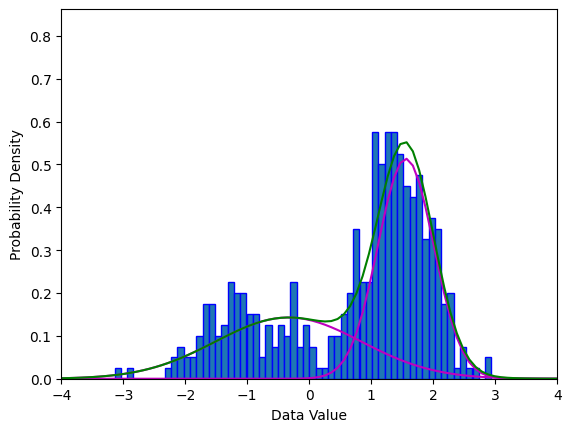

Log Likelihood After M-Step Iter 12 : -571.690

Bound After M-Step Iter 12 : -572.133

Log Likelihood After E-Step Iter 13 : -571.690

Bound After E-Step Iter 13 : -571.690



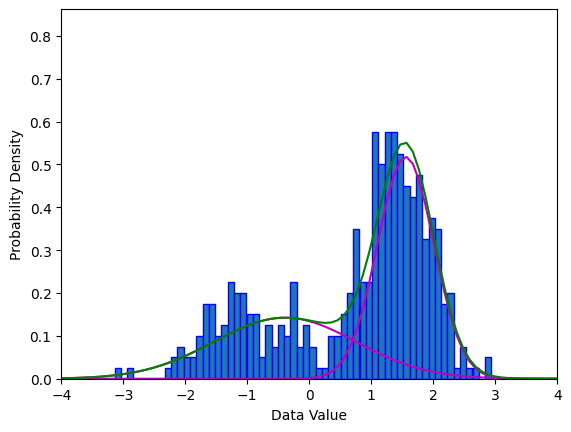

Log Likelihood After M-Step Iter 13 : -570.785

Bound After M-Step Iter 13 : -571.236

Log Likelihood After E-Step Iter 14 : -570.785

Bound After E-Step Iter 14 : -570.785



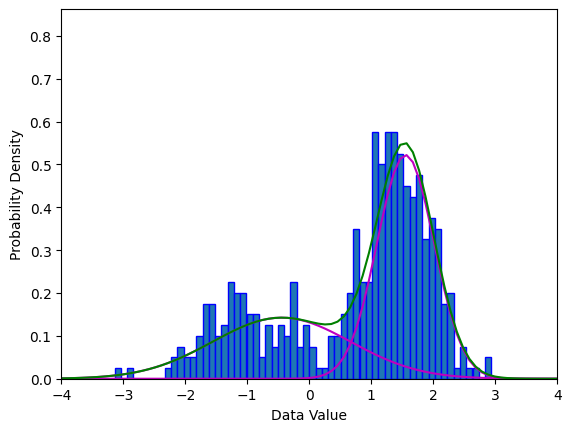

Log Likelihood After M-Step Iter 14 : -569.836

Bound After M-Step Iter 14 : -570.311

Log Likelihood After E-Step Iter 15 : -569.836

Bound After E-Step Iter 15 : -569.836



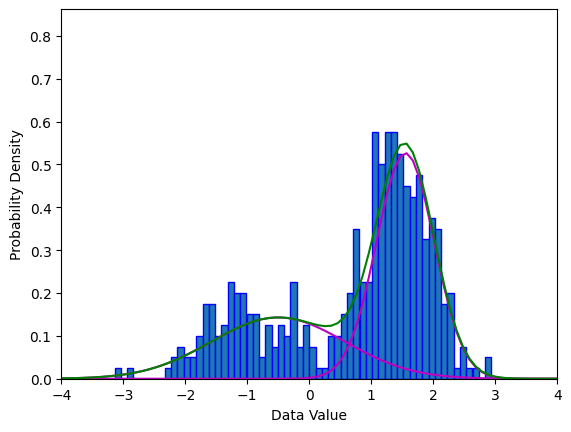

Log Likelihood After M-Step Iter 15 : -568.824

Bound After M-Step Iter 15 : -569.331

Log Likelihood After E-Step Iter 16 : -568.824

Bound After E-Step Iter 16 : -568.824



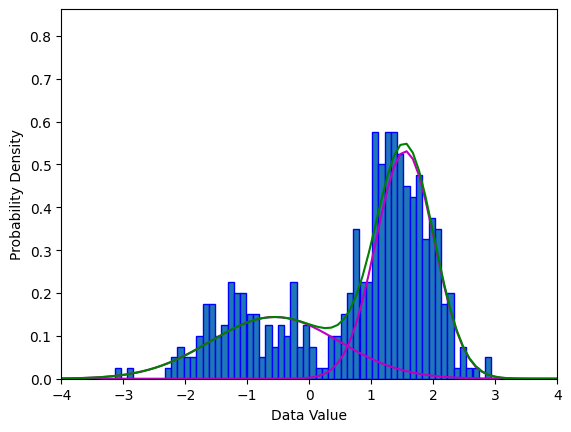

Log Likelihood After M-Step Iter 16 : -567.742

Bound After M-Step Iter 16 : -568.282

Log Likelihood After E-Step Iter 17 : -567.742

Bound After E-Step Iter 17 : -567.742



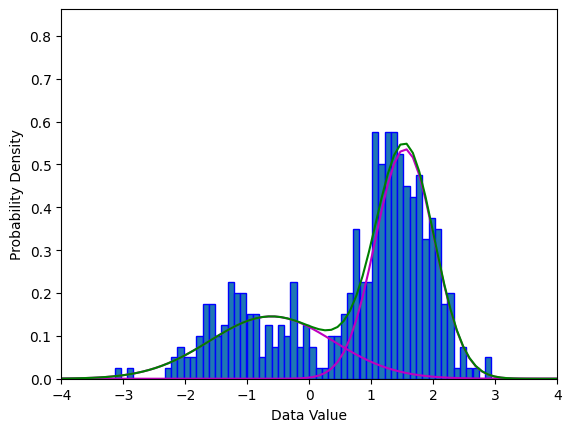

Log Likelihood After M-Step Iter 17 : -566.602

Bound After M-Step Iter 17 : -567.167

Log Likelihood After E-Step Iter 18 : -566.602

Bound After E-Step Iter 18 : -566.602



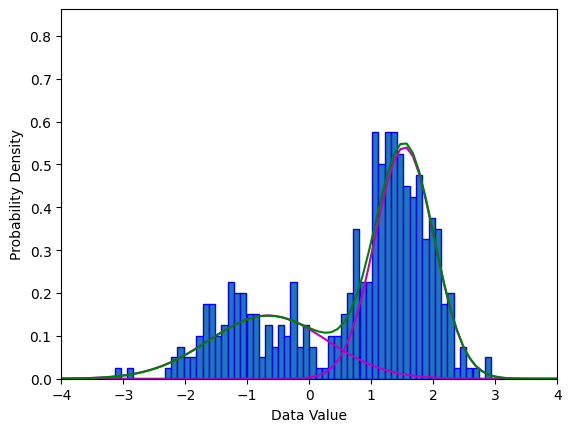

Log Likelihood After M-Step Iter 18 : -565.434

Bound After M-Step Iter 18 : -566.007

Log Likelihood After E-Step Iter 19 : -565.434

Bound After E-Step Iter 19 : -565.434



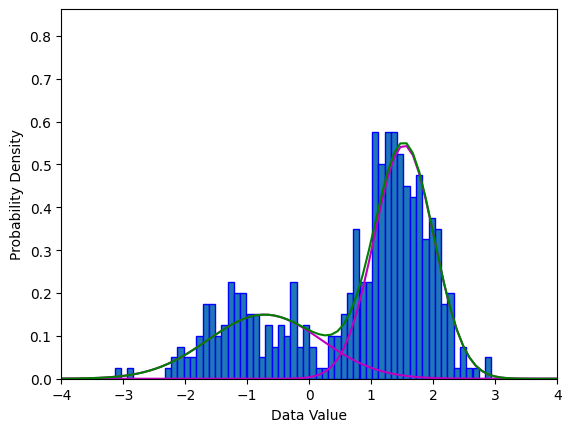

Log Likelihood After M-Step Iter 19 : -564.286

Bound After M-Step Iter 19 : -564.842



In [23]:
#generate data from the ground truth mixture of Gaussians we've defined way above. 
#make sure you've completed this routine above.
data = mixGaussGen1d(mixGaussTrue,nData)

#draw data, ground truth mixture of Gaussians.
drawEMData1d(data,mixGaussTrue)

#define number of components to estimate
nGaussEst = 2

#fit mixture of Gaussians (Pretend someone handed you some data. Now what?)
#Make sure you've completed this routine above.
mixGaussEst = fitMixGauss1d(data,nGaussEst)